In [1033]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import warnings

# Suppress warnings for cleaner output
warnings.simplefilter("ignore")

In [1034]:
# Load the dataset
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [1035]:
# Data inspection
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (891, 12)
Test data shape: (418, 11)


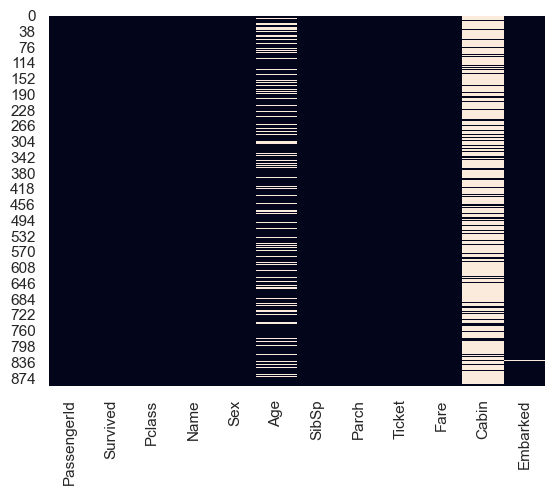

In [1036]:
# Visualize missing values
sns.heatmap(train_data.isnull(), cbar=False)
plt.show()

In [1037]:
# Print the age % of NaN values
age_nan_percent = train_data['Age'].isna().mean() * 100
print(f"Il y a {age_nan_percent:.2f}% d'âge qui manquent")

Il y a 19.87% d'âge qui manquent


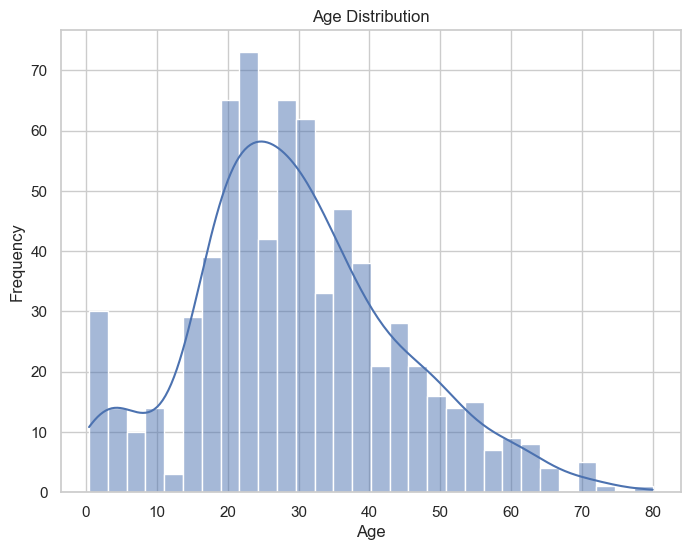

In [1038]:
# Plot the histogram of the age column
plt.figure(figsize=(8, 6))
sns.histplot(train_data['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [1039]:
# Print the median and mean of the age column
age_mean = train_data['Age'].mean()
age_median = train_data['Age'].median()
print(f"Moyenne : {age_mean:.2f}")
print(f"Médiane : {age_median:.2f}")

Moyenne : 29.70
Médiane : 28.00


In [1040]:
# Print the cabin % of NaN values
cabin_nan_percent = train_data['Cabin'].isna().mean() * 100
print(f"Il y a {cabin_nan_percent:.2f}% de Cabin qui manquent")

Il y a 77.10% de Cabin qui manquent


Distribution des passagers par port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton):
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


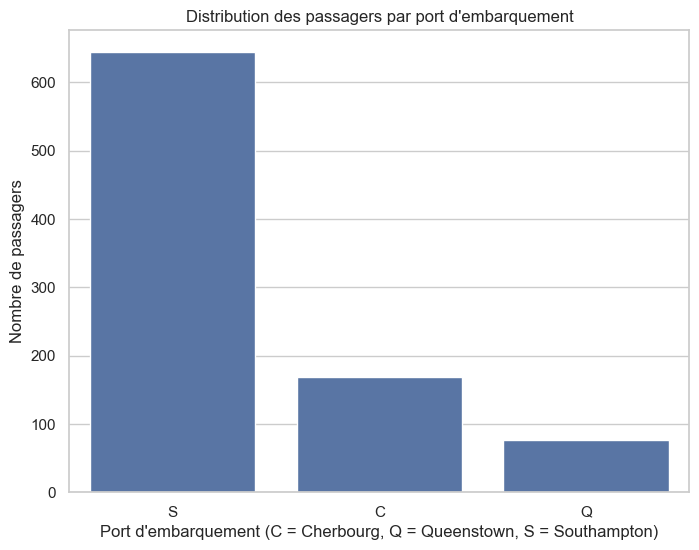

In [1041]:
# Print the embarked distribution
embarked_distribution = train_data['Embarked'].value_counts()
print("Distribution des passagers par port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton):")
print(embarked_distribution)

# Display the embarked distribution with a histogram
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='Embarked')
plt.title('Distribution des passagers par port d\'embarquement')
plt.xlabel('Port d\'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton)')
plt.ylabel('Nombre de passagers')
plt.show()

In [1042]:
# Impute missing "Age" with the median (28)
train_data['Age'].fillna(28, inplace=True)

# Impute missing "Embarked" with the most common value (mode), which is 'S'
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

# Drop the 'Cabin' column as it has too many missing values
train_data.drop(columns=['Cabin'], inplace=True)

# Verify the changes
print("Train Data after preprocessing:")
print(train_data.isnull().sum())  # Check for missing values



Train Data after preprocessing:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


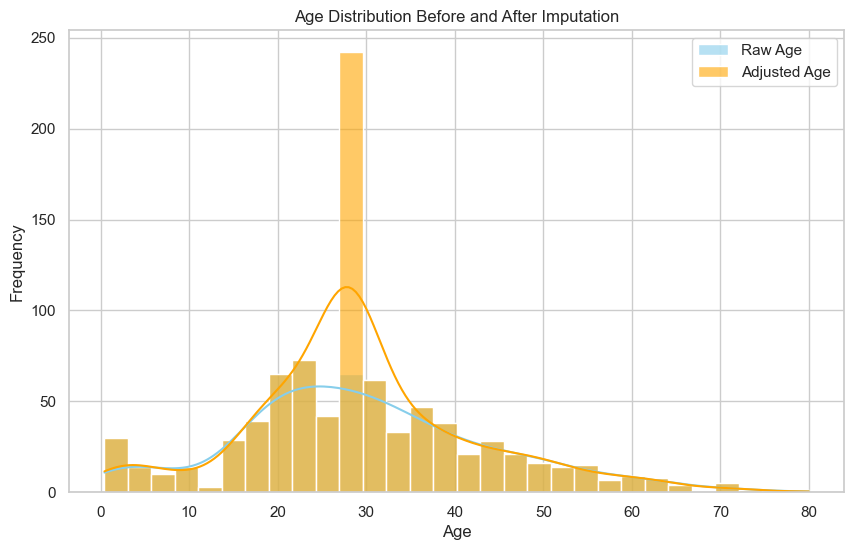

In [1043]:
train_data = pd.read_csv('data/train.csv')

# Create a copy of the "Age" column before imputation for comparison
age_before_imputation = train_data['Age'].copy()

# Impute missing "Age" values with the median (28)
train_data['Age'].fillna(28, inplace=True)
age_after_imputation = train_data['Age']

# Plot the histogram of "Age" before and after imputation on the same plot
plt.figure(figsize=(10, 6))
sns.histplot(age_before_imputation, kde=True, color='skyblue', label='Raw Age', bins=30, alpha=0.6)
sns.histplot(age_after_imputation, kde=True, color='orange', label='Adjusted Age', bins=30, alpha=0.6)

# Add title and labels
plt.title('Age Distribution Before and After Imputation')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Add a legend to distinguish between the two distributions
plt.legend()

# Show the plot
plt.show()

In [1044]:
# Create the 'TravelAlone' feature
train_data['TravelAlone'] = ((train_data['SibSp'] == 0) & (train_data['Parch'] == 0)).astype(int)

# Display the output with selected columns
print(train_data[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Embarked', 'TravelAlone']].head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  \
0                            Braund, Mr. Owen Harris    male  22.0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2                             Heikkinen, Miss. Laina  female  26.0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4                           Allen, Mr. William Henry    male  35.0   

             Ticket     Fare Embarked  TravelAlone  
0         A/5 21171   7.2500        S            0  
1          PC 17599  71.2833        C            0  
2  STON/O2. 3101282   7.9250        S            1  
3            113803  53.1000        S            0  
4            373450   8.0500        S            1  


In [1045]:
# Encode the categorical features with pd.get_dummies
train_data_encoded = pd.get_dummies(train_data, columns=['Pclass', 'Embarked', 'Sex'], drop_first=False)

# Display the first few rows to verify the changes
print(train_data_encoded.head())


   PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

    Age  SibSp  Parch            Ticket     Fare Cabin  TravelAlone  Pclass_1  \
0  22.0      1      0         A/5 21171   7.2500   NaN            0     False   
1  38.0      1      0          PC 17599  71.2833   C85            0      True   
2  26.0      0      0  STON/O2. 3101282   7.9250   NaN            1     False   
3  35.0      1      0            113803  53.1000  C123            0      True   
4  35.0      0      0            373450   8.0500   NaN            1     False   

   Pclass_2  Pclass_3  Embarked_C  Emb

In [1046]:
# Drop columns that are not needed for the analysis
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Cabin', 'Embarked_S', 'Sex_female']
train_data_encoded.drop(columns=columns_to_drop, axis=1, inplace=True)

# Display the first few rows to verify the results
print(train_data_encoded.head())

   Survived   Age     Fare  TravelAlone  Pclass_1  Pclass_2  Pclass_3  \
0         0  22.0   7.2500            0     False     False      True   
1         1  38.0  71.2833            0      True     False     False   
2         1  26.0   7.9250            1     False     False      True   
3         1  35.0  53.1000            0      True     False     False   
4         0  35.0   8.0500            1     False     False      True   

   Embarked_C  Embarked_Q  Sex_male  
0       False       False      True  
1        True       False     False  
2       False       False     False  
3       False       False     False  
4       False       False      True  


In [1055]:
print(test_data.isnull().sum())  # Check for missing values


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
TravelAlone      0
dtype: int64


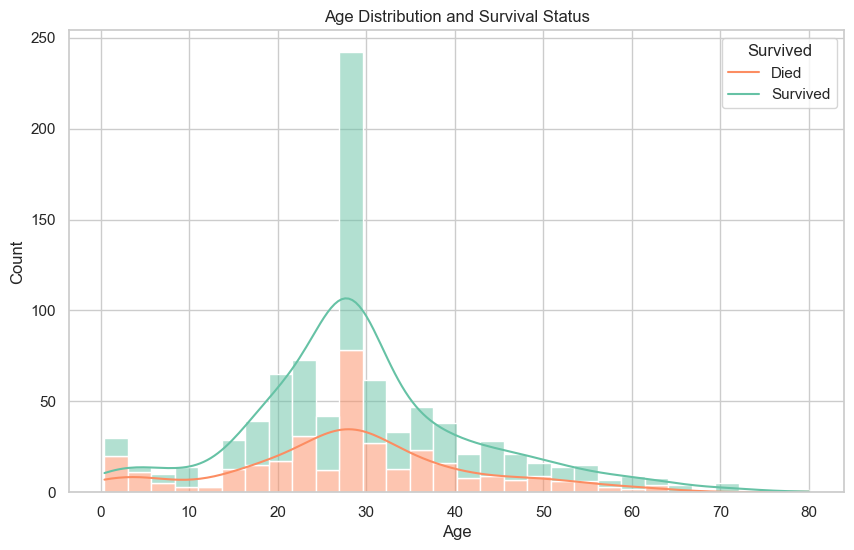

In [1048]:
# Plot the distribution of 'Age' with survival status
plt.figure(figsize=(10,6))
sns.histplot(train_data, x='Age', hue='Survived', multiple='stack', kde=True, palette='Set2')
plt.title('Age Distribution and Survival Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['Died', 'Survived'])
plt.show()

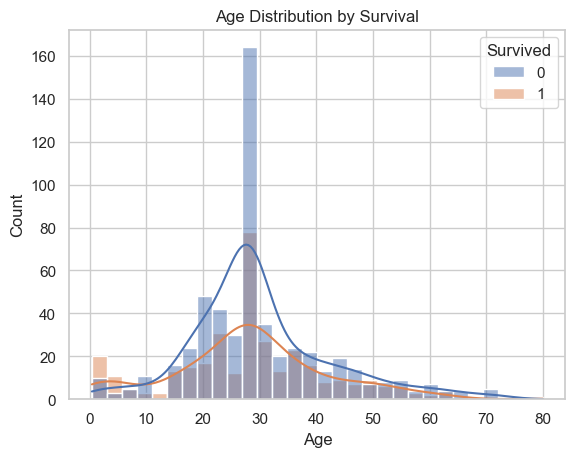

In [1049]:
# Create the "IsMinor" variable
train_data['IsMinor'] = train_data['Age'] < 16

# Plot the distribution of ages, colored by survival
sns.histplot(data=train_data, x='Age', hue='Survived', kde=True)
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

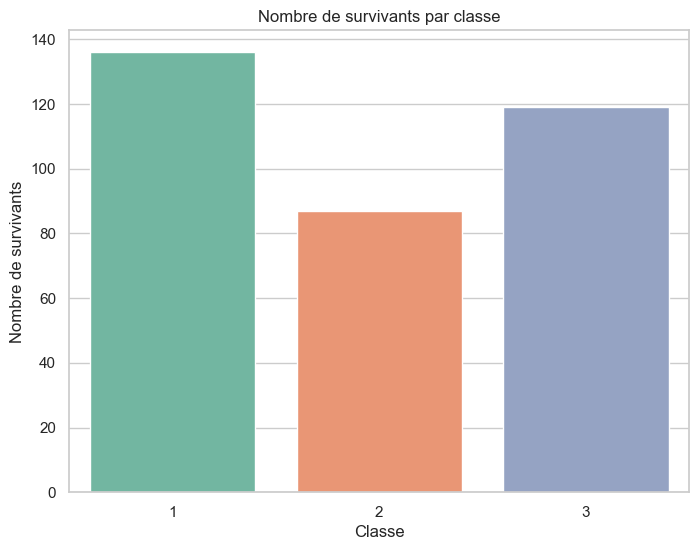

In [1050]:
survivors = train_data[train_data['Survived'] == 1]

# Créer le graphique
plt.figure(figsize=(8,6))
sns.countplot(data=survivors, x='Pclass', palette='Set2')
plt.title('Nombre de survivants par classe')
plt.xlabel('Classe')
plt.ylabel('Nombre de survivants')
plt.show()

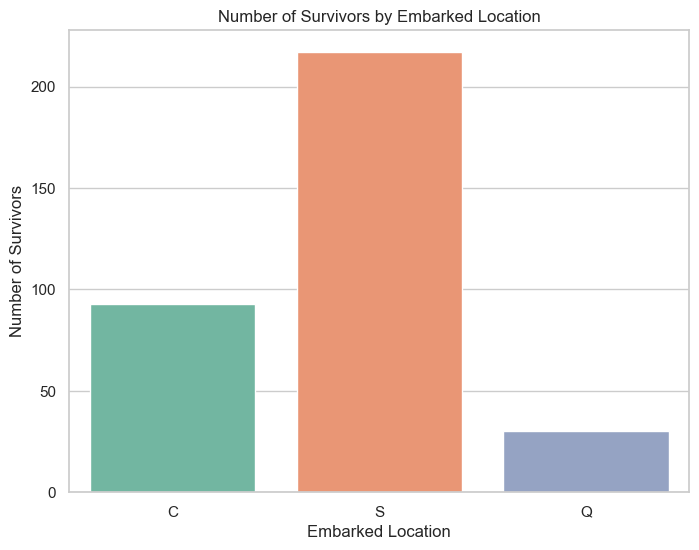

In [1051]:
# Filter data for survivors
survivors = train_data[train_data['Survived'] == 1]

# Plot survivors by embarked location
plt.figure(figsize=(8, 6))
sns.countplot(data=survivors, x='Embarked', palette='Set2')
plt.title('Number of Survivors by Embarked Location')
plt.xlabel('Embarked Location')
plt.ylabel('Number of Survivors')
plt.show()

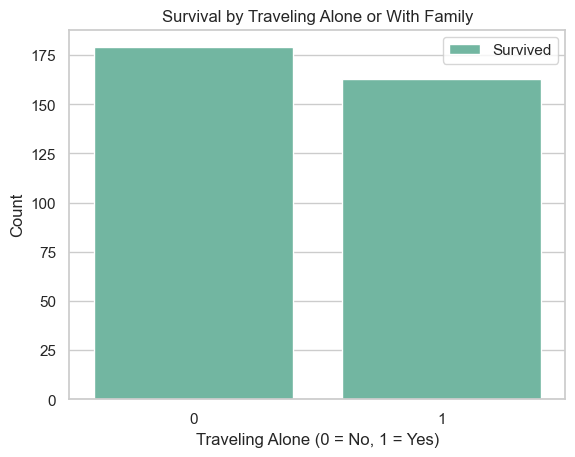

In [1052]:
# Filter data for survivors
survivors = train_data[train_data['Survived'] == 1]

# Plot survival status by traveling alone
sns.countplot(data=survivors, x='TravelAlone', hue='Survived', palette='Set2')
plt.title('Survival by Traveling Alone or With Family')
plt.xlabel('Traveling Alone (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.legend(labels=['Survived'])
plt.show()

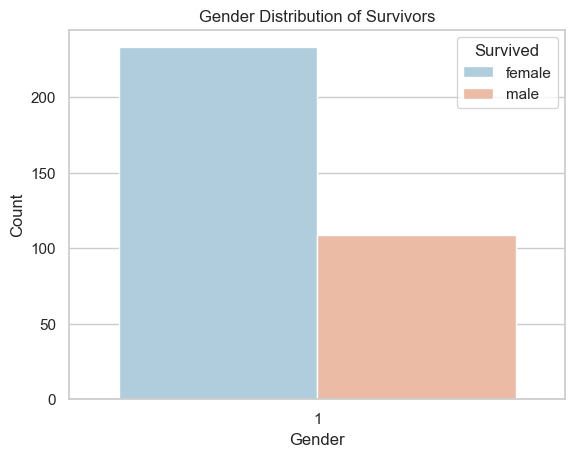

In [1053]:
# Filter data for survivors
survivors = train_data[train_data['Survived'] == 1]
# Plot survival by gender
sns.countplot(data=survivors, x='Survived', hue='Sex', palette='RdBu_r')
plt.title('Gender Distribution of Survivors')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['female', 'male'])
plt.show()


In [ ]:
#Logistic Regression with scikit-learn